## Gender Classification with SVMs using First Names

In [3]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Read the dataset
df = pd.read_csv("../assets/data/gender.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [6]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [7]:
# Convert each name to feature vector
X = []
y = []

# Considering the last character and bigrams in name
num_feats = 702    # 26 letters + 26*26 bigrams = 702 features

for i in range(len(df)):
  name = df.iloc[i]['Name']
  target = df.iloc[i]['Target']

  vec = np.zeros(num_feats)

  # Consider last character
  key = name[-1]
  if (ord(key) < 97 or ord(key) > 122):
    continue
  vec[ord(key)-97] +=1

  # Consider all bigrams
  for i in range(len(name)-1):
    bigram = name[i:i+2]
    # Skipping whitespace and extra characters if any
    if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[0]) < 97 or ord(bigram[1]) > 122):
      continue
    vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

  X.append(vec)

  if target == 0:
    # 0 represents girl
    y.append(-1)
  else:
    # 1 represents boy
    y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])

(702,)
1


In [8]:
# Split data into train and test sets
train_size = 0.8
test_size = 0.1
val_size = 0.1

data = list(zip(X, y))

# Split for training set
split_index_train = int(len(data) * (1 - test_size - val_size))
# Split for val set
split_index_val = int(len(data)*val_size)

train_data = data[:split_index_train]
val_data = data[split_index_train:split_index_train+split_index_val]
test_data = data[split_index_train+split_index_val:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)
y_train, y_test, y_val = np.array(y_train), np.array(y_test), np.array(y_val)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

print(f'Number of training examples: {X_train.shape, y_train.shape}')
print(f'Number of test examples: {X_test.shape, y_test.shape}')
print(f'Number of val examples: {X_val.shape, y_val.shape}')

Number of training examples: ((1034, 702), (1034, 1))
Number of test examples: ((130, 702), (130, 1))
Number of val examples: ((129, 702), (129, 1))


In [28]:
# Defining weights and bias for SVM. Unlike perceptron, we can not absorb the bias term in W.
W = np.zeros((num_feats, 1))
b = 0

In [29]:
# If C is very small, it will allow some points to fall inside the margin or classify them incorrectly in order to increase the margin. One the other hand if C is very large, it will try to classify each and every point correctly, but will produce a thin margin.
def train(X, y, W, b, learning_rate=0.1, C=0.1, num_iterations=500):
    m = X.shape[0]
    hinge_losses = []  # List to store the hinge loss at each iteration
    regularization_losses = []  # List to store the regularization loss at each iteration
    total_losses = []  # List to store the total loss at each iteration

    for iteration in range(num_iterations):
        z = y * (np.dot(X, W) + b)

        # margin_mask is set to true for all z < 1
        margin_mask = z < 1

        # Calculate gradients
        dW = (1/m)*((2*W) + C*(1-np.dot(X.T, y*margin_mask)))
        db = (1/m)*np.sum((C*margin_mask*(-y)))

        hinge_loss =  C*np.sum(1-np.dot(X.T, y*margin_mask))
        regularization_loss = np.sum(W * W)
        total_loss = hinge_loss + regularization_loss
        
        hinge_losses.append(hinge_loss)
        regularization_losses.append(regularization_loss)
        total_losses.append(total_loss)

        if (iteration % 100 == 0):
            print(f'Iteration: {iteration}, Total Loss: {total_loss}, Hinge Loss: {hinge_loss}, Regularization Loss: {regularization_loss}')

        W = W - learning_rate*dW
        b = b - learning_rate*db

    return W, b, hinge_losses, regularization_losses, total_losses


In [30]:
W, b, hinge_losses, regularization_losses, total_losses = train(X_train, y_train, W, b)

Iteration: 0, Total Loss: 71.7, Hinge Loss: 71.7, Regularization Loss: 0.0
Iteration: 100, Total Loss: 71.79613830728917, Hinge Loss: 71.7, Regularization Loss: 0.09613830728916546
Iteration: 200, Total Loss: 72.07722111762618, Hinge Loss: 71.7, Regularization Loss: 0.377221117626175
Iteration: 300, Total Loss: 71.83259775674998, Hinge Loss: 71.0, Regularization Loss: 0.8325977567499695
Iteration: 400, Total Loss: 39.91568315704764, Hinge Loss: 38.5, Regularization Loss: 1.415683157047641


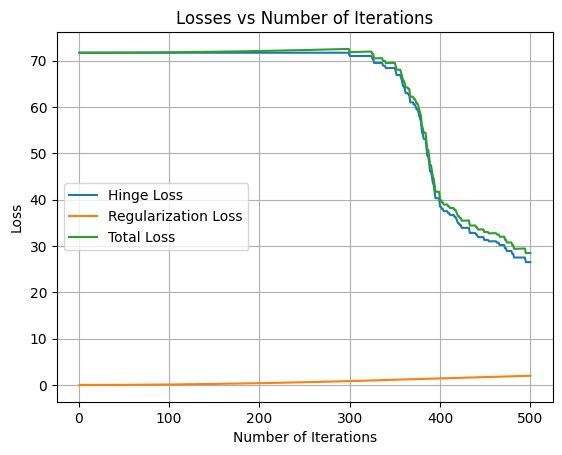

In [31]:
# Plot losses vs num_iterations
iterations = range(1, len(total_losses) + 1)

plt.plot(iterations, hinge_losses, label='Hinge Loss')
plt.plot(iterations, regularization_losses, label='Regularization Loss')
plt.plot(iterations, total_losses, label='Total Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Losses vs Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def get_accuracy(X, y, W, b):
    m = X.shape[0]
    print(f"Total number of test samples: {m}")

    z = y * (np.dot(X, W) + b)  # Compute all z values at once

    # mask is set to true for all misses i.e. z < 0
    mask = z < 0
    miss = np.sum(mask)

    print(f"Number of misclassified samples: {miss}")

    # Calculate and return accuracy
    accuracy = (m - miss) / m
    return accuracy

val_accuracy = get_accuracy(X_val, y_val, W, b)
print(f"Accuracy on Validation set: {val_accuracy}")


Total number of test samples: 129
Number of misclassified samples: 16
Accuracy on Validation set: 0.875968992248062


In [33]:
# Reset parameters for training again on combined dataset
W = np.zeros((num_feats, 1))
b = 0

In [34]:
# Training on both train and validation dataset
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
W, b, hinge_losses, regularization_losses, total_losses = train(X_train_val, y_train_val, W, b)

Iteration: 0, Total Loss: 74.0, Hinge Loss: 74.0, Regularization Loss: 0.0
Iteration: 100, Total Loss: 74.09935296613676, Hinge Loss: 74.0, Regularization Loss: 0.09935296613676181
Iteration: 200, Total Loss: 74.39066434823224, Hinge Loss: 74.0, Regularization Loss: 0.3906643482322376
Iteration: 300, Total Loss: 74.16385358267054, Hinge Loss: 73.3, Regularization Loss: 0.8638535826705435
Iteration: 400, Total Loss: 28.938403878696203, Hinge Loss: 27.5, Regularization Loss: 1.4384038786962032


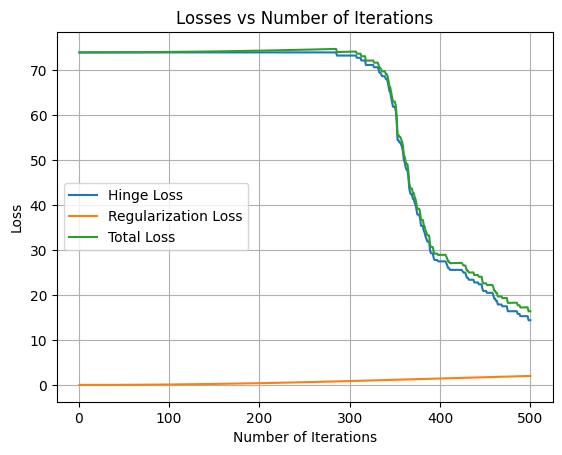

In [35]:
# Plot losses vs num_iterations
iterations = range(1, len(total_losses) + 1)

plt.plot(iterations, hinge_losses, label='Hinge Loss')
plt.plot(iterations, regularization_losses, label='Regularization Loss')
plt.plot(iterations, total_losses, label='Total Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Losses vs Number of Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
accuracy = get_accuracy(X_test, y_test, W, b)
print(f"Accuracy on test set: {accuracy}")

Total number of test samples: 130
Number of misclassified samples: 15
Accuracy on test set: 0.8846153846153846


In [37]:
def predict(test_name):
    # Convert name to feature vector
    name = test_name.lower()

    vec = np.zeros(num_feats)

    key = name[-1]
    vec[ord(key)-97] +=1

    # Consider all bigrams
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[0]) < 97 or ord(bigram[1]) > 122):
            continue
        vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

    z = (np.dot(vec, W) + b) 

    if z > 0:
        print("I am sure " + test_name + " is a boy.")
    elif z < 0:
        print("I am sure " + test_name + " is a girl.")

In [38]:
# Testing with our own example
predict("Chandan")
predict("Chandanbala")

I am sure Chandan is a boy.
I am sure Chandanbala is a girl.
